In [17]:
# Study Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Data preparation Libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
import optuna

# ML Libs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Discovery

In [18]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [21]:
df.duplicated().sum()

np.int64(1081)

We'll drop the duplicate, same amount, same caracteristics, same time... yeah...

In [22]:
df.drop_duplicates(inplace=True)

In [23]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No NaN, cool!

In [24]:
print('Frauds', round(len(df[df['Class'] == 1])/len(df) * 100,2), '% of the dataset')
print('No Frauds', round(len(df[df['Class'] == 0])/len(df) * 100,2), '% of the dataset')

Frauds 0.17 % of the dataset
No Frauds 99.83 % of the dataset


**Information:** Wow We have a huge disproportion here, we'll have to consider it during our ML phase.

## Exploration

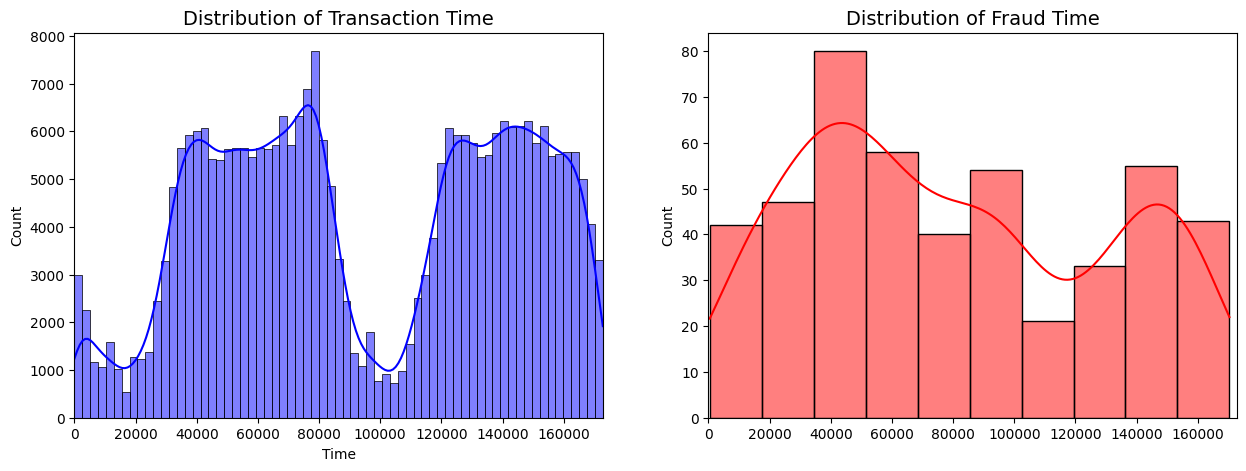

In [25]:
# Let's study the time!
# Time distribution:

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(df['Time'], color='b', kde=True)
plt.title('Distribution of Transaction Time', fontsize=14)
plt.xlim(min(df['Time']),max(df['Time']))

# Fraud distribution over time
plt.subplot(1,2,2)
sns.histplot(df[df['Class']==1]['Time'].values, color='r', kde=True)
plt.title('Distribution of Fraud Time', fontsize=14)
plt.xlim(min(df['Time']),max(df['Time']))

plt.show()

**Information:** Ok, It seems we have cycles, probably day/night! A day is 3600*24 = 86400s. So it seems reasonable to assume so, it seems to be the duration of a cycle. It also seems that we have more frauds in the day but we also have more transactions.

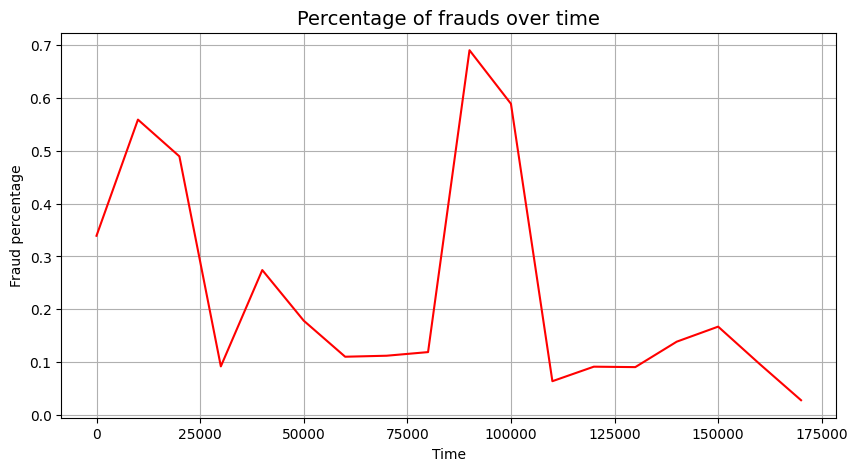

In [26]:
# We'll try to have the proportion of frauds by slices of time.

# We create bins of 10000s
bin_width = 10000
df['Time_bin'] = (df['Time'] // bin_width) * bin_width

# Now we calculate the percentage of frauds by time bin
fraude_ratio = df.groupby('Time_bin')['Class'].agg(['count', 'sum'])
fraude_ratio['fraude_ratio'] = (fraude_ratio['sum'] / fraude_ratio['count'])*100

# Let's plot!
plt.figure(figsize=(10,5))
sns.lineplot(x=fraude_ratio.index, y=fraude_ratio['fraude_ratio'], color='red')
plt.title('Percentage of frauds over time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Fraud percentage')
plt.grid(True)
plt.show()


**Information:** Okay! So the proportion seems to be more important at times where there is fewer transactions. It was kind of predictable by looking at the thin difference of fraud count in the previous graph but heh, now we know!

Amount infos
count    283726.000000
mean         88.472687
std         250.399437
min           0.000000
25%           5.600000
50%          22.000000
75%          77.510000
max       25691.160000
Name: Amount, dtype: float64
Amount infos on Fraud transactions
count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


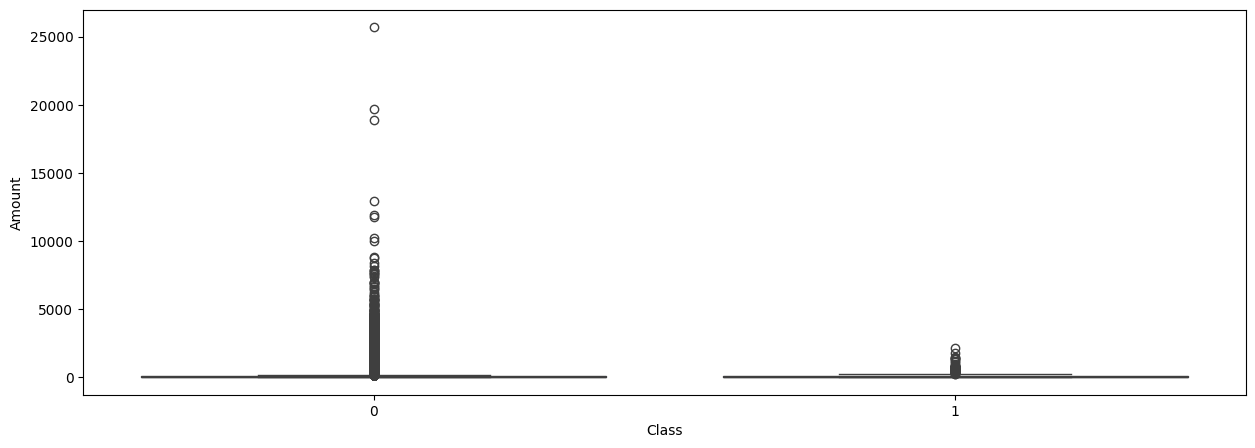

In [27]:
# Let's talk about amounts now!
print('Amount infos')
print(df['Amount'].describe())
print('Amount infos on Fraud transactions')
print(df[df['Class']==1]['Amount'].describe())

plt.figure(figsize=(15,5))
sns.boxplot(data = df, x='Class', y='Amount')
# plt.ylim(-100, max(df[df['Class']==1]['Amount'])+200)
plt.show()

**Information:** Ok on global the mean and median of transactions are quite low. The STD is quite similar between Fraud and not Fraud. The mean and median is higher in the Fraud section however. A bit informative but not too much here...

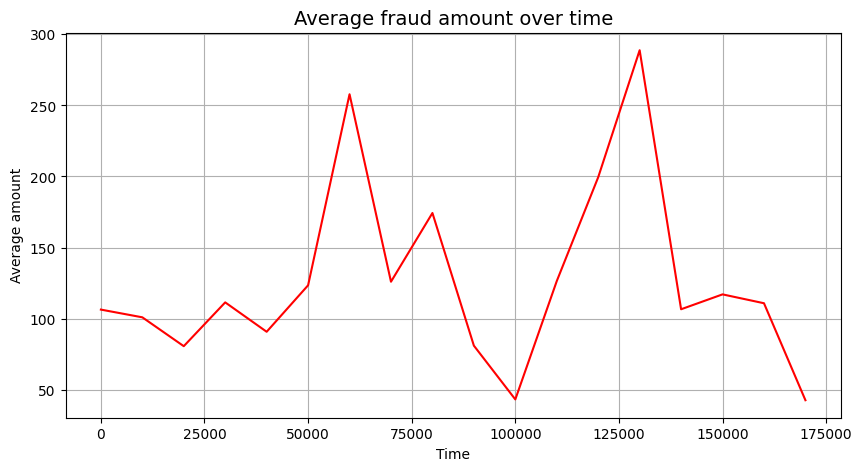

In [28]:
# We'll try to have the proportion of frauds by slices of time.

# We create bins of 10000s
bin_width = 10000
df['Time_bin'] = (df['Time'] // bin_width) * bin_width

# Now we calculate the percentage of frauds by time bin
fraud_amount = df[df['Class'] ==1].groupby('Time_bin')['Amount'].agg(['mean'])
# fraude_amount['fraude_amount'] = (fraude_ratio['sum'] / fraude_ratio['count'])*100

# Let's plot!
plt.figure(figsize=(10,5))
sns.lineplot(x=fraud_amount.index, y=fraud_amount['mean'], color='red')
plt.title('Average fraud amount over time', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Average amount')
plt.grid(True)
plt.show()

## Features exploration

**Let's talk about features!**

Now we'll talk about feature importance. We'll try to understand which feature has an influence on the target.
To do that we'll have to change the propotion to avoid the noise of the vast majority of non fraud.
We'll have to SPLIT!
Why? We want something robust, precise, so we'll make our study on a train set, 
leaving our test set out to have a maximum of reality coming into our model during the final prediction.

In [29]:
X= df.drop(columns=['Class', 'Time_bin'])
y= df['Class']

In [30]:
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
# Let's scale the time and amout! We use Robust scaler, he is more robust with the presence of outliers

scaler= RobustScaler()

X_rescaled = scaler.fit_transform(X_original_train[['Amount', 'Time']])
X_rescaled = pd.DataFrame(X_rescaled, columns=['scaled_amount', 'scaled_time'], index=X_original_train.index)
X_original_train = pd.concat([X_original_train, X_rescaled], axis=1)
X_original_train.drop(columns=['Amount', 'Time'], inplace= True)
display(X_original_train.tail(3))

# Ok now for the test part! We only transform her, no data leak!

X_rescaled_t = scaler.transform(X_original_test[['Amount', 'Time']])
X_rescaled_t = pd.DataFrame(X_rescaled_t, columns=['scaled_amount', 'scaled_time'], index=X_original_test.index)
X_original_test = pd.concat([X_original_test, X_rescaled_t], axis=1)
X_original_test.drop(columns=['Amount', 'Time'], inplace= True)
display(X_original_test.tail(3))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
242674,-0.875424,1.159992,0.573970,1.178888,-0.206267,0.260623,0.371124,0.443532,-0.011588,-0.192711,...,-0.100597,-0.157726,0.049751,-0.014156,-0.513855,-0.771982,-0.242970,0.094879,0.206763,0.784493
60594,1.247036,0.348595,0.589407,0.982998,-0.222000,-0.452687,-0.012336,-0.140168,0.052173,-0.069423,...,-0.211495,-0.556038,0.037106,-0.133330,0.403622,-0.595756,0.043911,0.032002,-0.236696,-0.416118
67057,1.024661,-0.223567,0.521926,0.679175,0.146810,1.460143,-0.482834,0.503958,0.609685,-0.414094,...,0.014869,0.428601,0.053139,-0.890781,0.235724,0.538489,0.057025,-0.001364,-0.135394,-0.381450


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
115561,1.180651,-0.199219,1.233565,0.869184,-1.138767,-0.315881,-0.660840,0.103571,1.011595,-0.224579,...,-0.097776,-0.114066,0.037897,0.419476,0.236291,0.318145,0.013352,0.026229,-0.179324,-0.128098
187644,2.061059,0.136698,-1.830805,0.206364,0.705093,-0.326154,0.107304,-0.093259,0.184680,-0.223070,...,-0.332798,-0.861005,0.274903,0.113347,-0.219966,0.176290,-0.063574,-0.043578,-0.293653,0.502887
8267,1.247134,0.061041,0.888561,0.317248,-0.756993,-0.814185,-0.380703,-0.249083,1.611285,-0.544455,...,-0.057021,0.136372,-0.024868,0.437795,0.235011,1.027893,-0.084075,0.007707,-0.084950,-0.866387


Now that we have split, we can play on the train, we will start by evaluating the feature importance.
We will start with the ROC AUC. The advantage of the ROC AUC is that our class imbalance is not a problem with this metric.

*What is it?*
The Univariate AUC analysis measures the capacity of target class separation of a feature.
The analysis tests multiples thresholds (a threshold is a value of our feature in general) on the feature and ask the question: 
"Will my target will be 1 if the feature is above this thershold?"
Like a simple classifier, it then give us True Positive Rates (TPR) and False Positive Rates (FPR) and then it plots the TPR against the FPR.

*How do we read it?*
We have a curve and we take the Area Under the Curve. If this area is close to 1, the feature is a great separator.
If the area is 0.5, it's pure random.
If the area is lower than 0.5, the more it goes to 0 the more we should do the opposite of the feature to make a good separation.

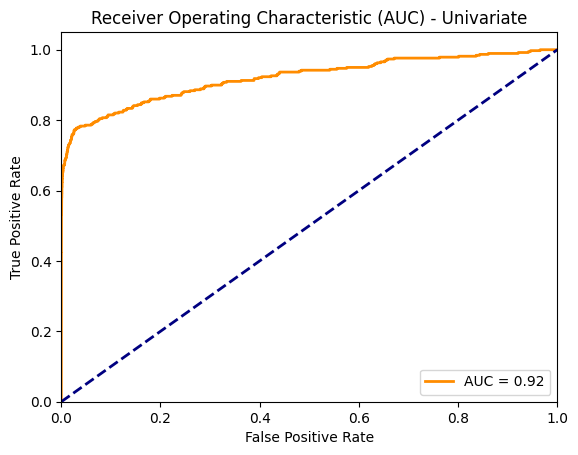

In [32]:
# Exemple avec la feature 'V14' et les labels 'y'
fpr, tpr, thresholds = roc_curve(y_original_train, X_original_train['V11'])
roc_auc = auc(fpr, tpr)

# Tracer la ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC) - Univariate')
plt.legend(loc='lower right')
plt.show()

In [33]:
df_roc_auc = pd.DataFrame()
i=0
for col in X_original_train.columns:
    fpr, tpr, thresholds = roc_curve(y_original_train, X_original_train[col])
    roc_auc = auc(fpr, tpr)
    df_roc_auc.loc[i, 'Cols'] = col
    df_roc_auc.loc[i, 'ROC_AUC'] = roc_auc
    i+= 1
display(df_roc_auc.sort_values('ROC_AUC', ascending= False))

,Cols,ROC_AUC
3,V4,0.936090
10,V11,0.919791
1,V2,0.858452
20,V21,0.743726
26,V27,0.702895
18,V19,0.663593
7,V8,0.662813
19,V20,0.659014
27,V28,0.653864
25,V26,0.541579


Now we'll try something else. The Pearson correlation. The problem with that is that we have a heavily imbalanced dataset.
To avoid noise we'll have to balance this.

*How?*
Undersampling. We'll create a smaller df with all the frauds and the same number of non-fraud. It will help us to have a clearer view of the correlation
BUT!
Doing that we'll have a huge bias, the random sample of non fraud used may be extremely specific and give us misleading correlations.

*What do we do?*
First we have the ROC AUC. If we have a huge problem we'll see it.
Secondly won't use only the undersampler created. We'll create 10-15 different undersampled datasets (because of the dataset size) and a correlation matrix for each.
Then, we'll calculate the average correlation matrix using all the previous matrixes.

In [34]:
df_train = pd.concat((X_original_train,y_original_train), axis = 1)

frauds = df_train[df_train['Class'] == 1]
non_frauds = df_train[df_train['Class'] == 0]

# Let's go with 10 samples
num_samples = 10

# We'll stock our cute little dataframes here
undersampled_datasets = []

for i in range(num_samples):
    # Non fraud collection
    non_frauds_sample = non_frauds.sample(n=len(frauds), random_state=i)
    
    # Balanced dataset creation
    undersampled_df = pd.concat([frauds, non_frauds_sample])
    
    # Adding the ne dataset to the list
    undersampled_datasets.append(undersampled_df)

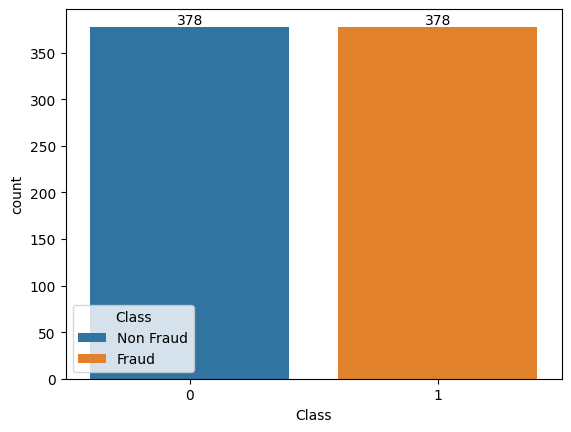

In [35]:
# Let's check our repartition on the first dataset of the list
ax =sns.barplot(data=undersampled_datasets[0]['Class'].value_counts().reset_index(), x='Class', y='count', hue= 'Class')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

new_labels = ['Non Fraud', 'Fraud']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=new_labels, title='Class')
plt.show()

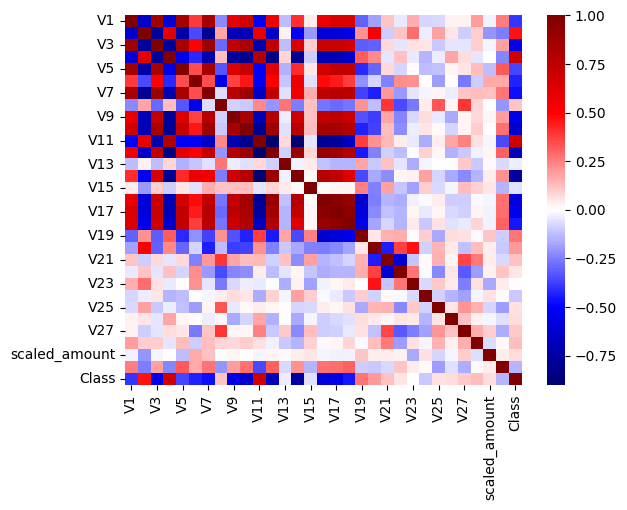

In [36]:
# Let's look at a heatmap!

sns.heatmap(data= undersampled_datasets[0].corr(), cmap = "seismic", center = 0)
plt.show()

Nice carpet. Now we'll take the line of the correlation matrix corresponding to the class

In [37]:
corr_matrix_0 = undersampled_datasets[0].corr()['Class']
display(corr_matrix_0.sort_values(ascending = False).drop('Class'))

V4               0.687586
V11              0.686274
V2               0.462583
V19              0.268287
V20              0.198171
V28              0.127623
V21              0.122402
V8               0.111026
V27              0.107110
scaled_amount    0.067922
V26              0.066144
V25              0.058322
V22              0.051466
V23              0.000381
V13             -0.036119
V15             -0.059369
V24             -0.104805
scaled_time     -0.142655
V5              -0.366246
V1              -0.394978
V6              -0.430948
V18             -0.450690
V7              -0.476917
V3              -0.555156
V9              -0.557259
V17             -0.559341
V16             -0.590264
V10             -0.636274
V12             -0.688914
V14             -0.755496
Name: Class, dtype: float64

It really look like the order of the ROC AUC Score, we're not out of the blue!

In [44]:
# Now we'll make the average correlation matrix

df_matrix= pd.DataFrame()
for mini_df in undersampled_datasets:
    matrix =  mini_df.corr()['Class'].drop('Class')
    df_matrix = pd.concat((df_matrix,matrix), axis = 1)

df_matrix_mean = df_matrix.T.mean()
display(df_matrix_mean.sort_values(ascending=False))

V4               0.694952
V11              0.682473
V2               0.488730
V19              0.267727
V20              0.174797
V8               0.117900
V21              0.117867
V27              0.109711
V28              0.098666
V26              0.071324
V22              0.053921
scaled_amount    0.043492
V25              0.032405
V23             -0.033072
V13             -0.039520
V15             -0.039940
V24             -0.116133
scaled_time     -0.122918
V5              -0.365755
V1              -0.419931
V6              -0.433212
V18             -0.460179
V7              -0.473125
V9              -0.553796
V17             -0.559065
V3              -0.564116
V16             -0.592947
V10             -0.633316
V12             -0.685815
V14             -0.754814
dtype: float64

Ok, Everything seems to be coherent here.

## Machine Learning